In [1]:
# import thư viện và crawl data về
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import pickle

# đọc dữ liệu
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

# tách thành features và target
X_train = train_data.drop(['median_house_value'], axis=1)
y_train = train_data['median_house_value']

X_test = test_data.drop(['median_house_value'], axis=1)
y_test = test_data['median_house_value']

X_val = val_data.drop(['median_house_value'], axis=1)
y_val = val_data['median_house_value']


KeyError: "['median_house_value'] not found in axis"

In [51]:
# hàm dùng để đánh giá hiệu suất của mô hình
def performance_metrics_cal(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"XGB \n MAE : {mae:.2f}\n MSE: {mse:.2f}\n R²: {r2:.5f}\n")

# mô hình sử dụng XGBoost

In [54]:
# train model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

In [55]:
# đánh giá mô hình khi chưa tối ưu
performance_metrics_cal(y_true=y_test, y_pred=y_pred)

XGB 
 MAE : 32623.23
 MSE: 2391216773.79
 R²: 0.81654



# optimize using optuna

In [41]:
import optuna

# hàm objective
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2,  0.75),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 0.45),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    return mse

In [42]:
# sử dụng optuna để đưa ra tập các hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=70)

[I 2024-12-05 16:52:22,100] A new study created in memory with name: no-name-22b0dfd1-3c24-4051-b0b3-a2678ad24455
[I 2024-12-05 16:52:23,047] Trial 0 finished with value: 2089553326.6367595 and parameters: {'learning_rate': 0.10216176460372697, 'max_depth': 6, 'subsample': 0.5421762838885886, 'colsample_bytree': 0.5288003574409845, 'reg_alpha': 0.3670045517499823, 'reg_lambda': 0.2853990585968162, 'min_child_weight': 15}. Best is trial 0 with value: 2089553326.6367595.
[I 2024-12-05 16:52:23,798] Trial 1 finished with value: 2244489047.829144 and parameters: {'learning_rate': 0.022028733083033183, 'max_depth': 5, 'subsample': 0.8814494279573384, 'colsample_bytree': 0.5626215744807626, 'reg_alpha': 0.05476039940903906, 'reg_lambda': 0.04376618604887524, 'min_child_weight': 1}. Best is trial 0 with value: 2089553326.6367595.
[I 2024-12-05 16:52:24,317] Trial 2 finished with value: 2275372224.3427978 and parameters: {'learning_rate': 0.10805469809995429, 'max_depth': 3, 'subsample': 0.854

In [43]:
# in ra tập hyperparameters tối ưu nhất tìm được
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.04521875270021727, 'max_depth': 8, 'subsample': 0.8818962360847956, 'colsample_bytree': 0.5695881645464036, 'reg_alpha': 0.6804277732802362, 'reg_lambda': 0.12101035389986839, 'min_child_weight': 13}
Best RMSE: 1907729658.0467885


In [56]:
# lưu best params 
opt_para = {
    "objective": "reg:squarederror",
    "n_estimators": 1000,
    "verbosity": 0,
    "learning_rate": 0.04521875270021727,
    "max_depth": 8,
    "subsample": 0.8818962360847956,
    "colsample_bytree": 0.5695881645464036,
    "reg_alpha": 0.6804277732802362,
    "reg_lambda": 0.12101035389986839,
    "min_child_weight": 13,
}

đánh giá model sau khi được tối ưu

In [57]:
# Kiểm tra final model
opt_model = XGBRegressor(**opt_para2)
opt_model.fit(X_train, y_train, verbose=False)
y_pred = opt_model.predict(X_test)
performance_metrics_cal(y_test, y_pred)

XGB 
 MAE : 29765.51
 MSE: 2041399093.40
 R²: 0.84338



lưu model

In [58]:
with open('optimized_xgboost.pkl', 'wb') as f:
    pickle.dump(opt_model, f)

# so sánh mô hình trước và sau khi tối ưu bằng biểu đồ

In [62]:
metrics = ['MAE', 'MSE', 'R²']
before_optimization = [32623.23, 2391216773.79, 0.81654]
after_optimization = [29765.51, 2041399093.40, 0.84338]

normalized_mse_before = before_optimization[1] / 1e9  
normalized_mse_after = after_optimization[1] / 1e9

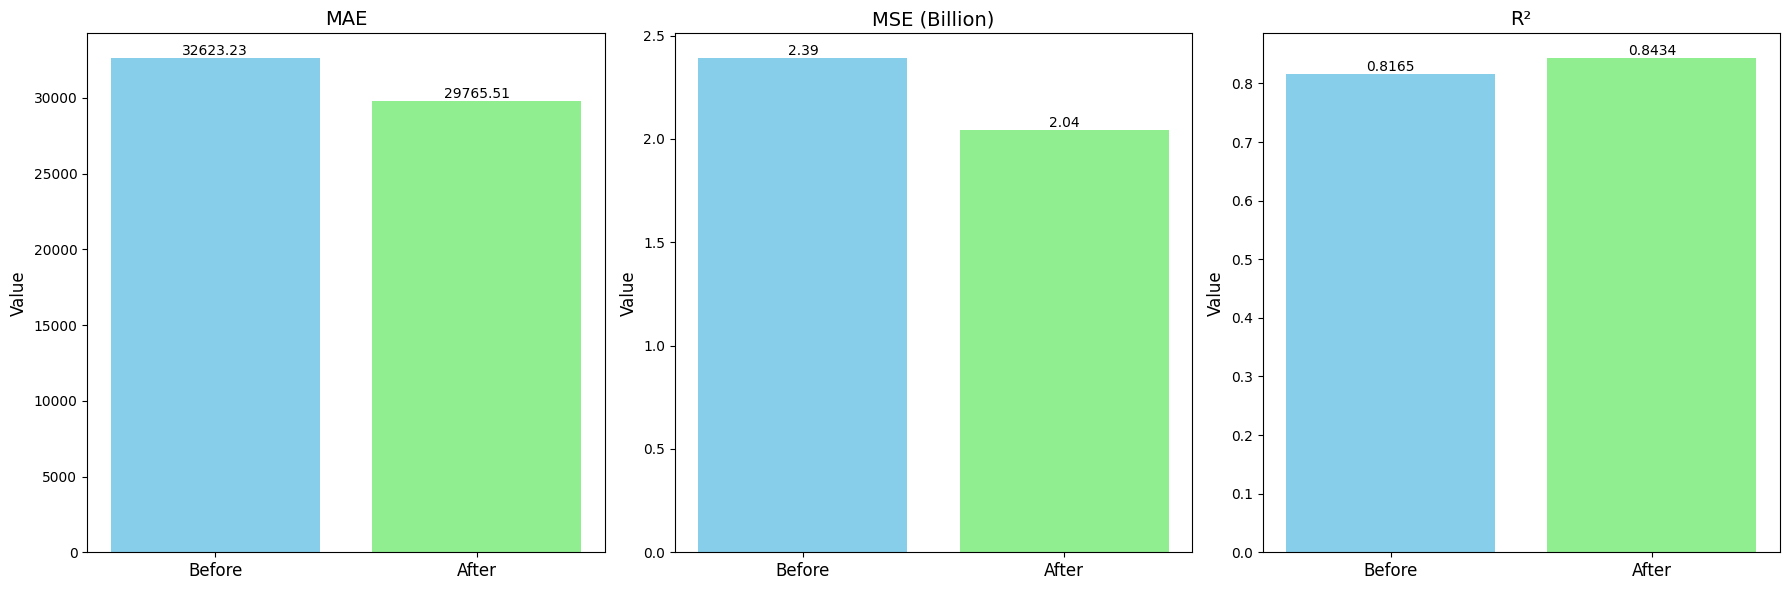

In [63]:
# Data for each metric
metrics_individual = ['MAE', 'MSE (Billion)', 'R²']
before_values = [before_optimization[0], normalized_mse_before, before_optimization[2]]
after_values = [after_optimization[0], normalized_mse_after, after_optimization[2]]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each metric and create individual plots
for i, ax in enumerate(axes):
    ax.bar(['Before', 'After'], [before_values[i], after_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics_individual[i], fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Before', 'After'], fontsize=12)
    
    # Annotate bars
    for j, value in enumerate([before_values[i], after_values[i]]):
        ax.text(j, value, f'{value:.2f}' if i < 2 else f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()